In [1]:
import tensorflow as tf
import numpy as np

#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from pyDOE import lhs

np.random.seed(1234)
tf.set_random_seed(1234)
%matplotlib inline

/home/qri/miniconda3/envs/DL/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [23]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, XYT, U, Indices, layers, WELLs, PermModel, gamma, phi, relpermn):
        #XYT: n by 3 arrays, columns: x, y, t
        #U: n by 1 arrays storing the value of physics quantities to enforce (initial condition, boundary conditions, etc)
        #Indices: storing the indices of U that gives values of vx, vy and sw to match in the training process
        #PermModel: a permeability model
        #WELL: list of wells with location and rate [{x: x coord, y: y coord, Q: rate}, {}, ..] positive rate: injector, negative rate: producer
        
        self.WR = 0.03 #radius of well impacting area
        self.Walpha = 0.5/self.WR/self.WR #1/2sigma^2
    
        self.gamma, self.phi, self.relpermn = gamma, phi, relpermn
        self.WELLs = WELLs

        self.PermModel = PermModel
        
        vxi,vxj, vyi, vyj, swi, swj =   Indices['vx']['begin'], Indices['vx']['end'],\
                                        Indices['vy']['begin'], Indices['vy']['end'],\
                                        Indices['sw']['begin'], Indices['sw']['end']
        print(vxi,vxj,vyi,vyj,swi,swj)
        self.x = XYT[:,0:1]
        self.y = XYT[:,1:2]
        self.t = XYT[:,2:3]
        self.u = U
        self.r = self.computeR(XYT[:,0:2],self.WELLs) 
        self.dlnk = self.PermModel.getdlnKdxy(XYT[:,0],XYT[:,1]) #get dlnK/dx and dlnK/dy at given locations
        
        
        self.layers = layers
        self.layers[0] = 3 + len(self.WELLs)
        
        self.lb = np.r_[XYT.min(axis=0),self.r.min(axis=0)]
        self.ub = np.r_[XYT.max(axis=0),self.r.max(axis=0)]
        #self.lb = XYT.min(axis=0)
        #self.ub = XYT.max(axis=0)
        print(self.lb)
        print(self.ub)
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, 1], name='x')
        self.y_tf = tf.placeholder(tf.float32, shape=[None, 1], name='y')
        self.t_tf = tf.placeholder(tf.float32, shape=[None, 1], name='t')
        self.r_tf = tf.placeholder(tf.float32, shape=[None, self.r.shape[1]], name='r')
        self.u_tf = tf.placeholder(tf.float32, shape=[None, 1], name='u')
        self.dlnk_tf = tf.placeholder(tf.float32, shape=[None, self.dlnk.shape[1]], name='dlnK')
        
        self.U_pred = \
            self.net_u(self.x_tf, self.y_tf, self.t_tf, self.r_tf, self.dlnk_tf)

        self.loss_vx = tf.reduce_mean(tf.square(self.U_pred[vxi:vxj,0:1] - self.u_tf[vxi:vxj,0:1])) #enforce vx
        self.loss_vy = tf.reduce_mean(tf.square(self.U_pred[vyi:vyj,1:2] - self.u_tf[vyi:vyj,0:1])) #enforce vy
        self.loss_sw = tf.reduce_mean(tf.square(self.U_pred[swi:swj,2:3] - self.u_tf[swi:swj,0:1])) #enforce sw
        
        self.loss_fp  = tf.reduce_mean(tf.square(self.U_pred[:,3:4])) #enforce fp
        self.loss_fs  = tf.reduce_mean(tf.square(self.U_pred[:,4:5])) #enforce fs
        self.loss_fv  = tf.reduce_mean(tf.square(self.U_pred[:,5:6])) #enforce fv

        self.loss = self.loss_sw + self.loss_vx + self.loss_vy + self.loss_fp + self.loss_fs + self.loss_fv 
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 500,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 2.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = 0.0003)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def computeR(self,XY,WELLs):
        r = np.zeros((XY.shape[0],len(WELLs))) #compute distance of each point from each well
        for i, well in enumerate(WELLs):
            r[:,i] = np.log(np.sqrt(np.sum(np.power(XY-[well['x'],well['y']],2),axis=1)))
        return r


    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)    
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, XYTR, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(XYTR - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            #if (l<num_layers-6) and (l%2==0):
            #    H = tf.nn.leaky_relu(tf.add(tf.matmul(H, W), b))
            #else:
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        
        return Y
    
    def net_u(self, x, y, t, r, dlnkxy):
        u = self.neural_net(tf.concat([x,y,t,r],1), self.weights, self.biases)
        #u = self.neural_net(tf.concat([x,y,t],1), self.weights, self.biases)
        vx, vy, sw = u[:,0:1], u[:,1:2], tf.sigmoid(u[:,2:3])
        
        if self.relpermn==1:
            if self.gamma==1:
                mobility = 1
            else:
                mobility = self.gamma*(1-sw) + sw
        else:
            mobility = self.gamma*tf.pow(1-sw,self.relpermn)+tf.pow(sw,self.relpermn)

        Fw = tf.pow(sw, self.relpermn)/mobility
    
        Q_prod = 0
        Q_inj = 0

        for well in self.WELLs:
            if  well['rate']>0: #injector
                Q_inj = Q_inj + well['rate']*self.Walpha/3.1415927* \
                            tf.exp(-self.Walpha*(tf.pow(x- well['x'],2)+tf.pow(y-well['y'],2)))
            else:
                Q_prod = Q_prod +  well['rate']*self.Walpha/3.1415927* \
                            tf.exp(-self.Walpha*(tf.pow(x-well['x'],2)+tf.pow(y-well['y'],2)))
        
        Q_o = Q_prod*(1-Fw)
        Q_w = Q_inj + Q_prod*Fw
        
        p_eqn_LHS = tf.gradients(mobility*vx,x)[0]+tf.gradients(mobility*vy,y)[0]
        p_eqn_RHS = Q_inj + Q_prod

        s_eqn_LHS = self.phi*tf.gradients(sw,t)[0] \
            + tf.gradients(tf.pow(sw,self.relpermn)*vx,x)[0] \
            + tf.gradients(tf.pow(sw,self.relpermn)*vy,y)[0]
        s_eqn_RHS = Q_w
        
        v_eqn_LHS = tf.gradients(vx,y)[0] - tf.gradients(vy,x)[0]
        v_eqn_RHS = 0#tf.multiply(dlnkxy[:,0:1],vx) - tf.multiply(dlnkxy[:,1:2],vy)

        f_p = p_eqn_LHS - p_eqn_RHS
        f_s = s_eqn_LHS - s_eqn_RHS
        f_v = v_eqn_LHS - v_eqn_RHS        
        
        return tf.concat([vx,vy,sw,f_p,f_s,f_v],1)
    
    def callback(self, loss, loss_sw, loss_vx, loss_vy, loss_fp, loss_fs, loss_fv):
        self.iter += 1
        if (self.iter % 50 == 0):
            print('Iter: %05d, Loss: %.2e, sw: %.2e, vx: %.2e, vy: %.2e, fp: %.2e, fs: %.2e, fv: %.2e' % \
                  (self.iter,  loss, loss_sw, loss_vx, loss_vy, loss_fp, loss_fs, loss_fv))
        
    def train(self,nIter_adam):

        tf_dict = {self.x_tf: self.x, 
                   self.y_tf: self.y, 
                   self.t_tf: self.t, 
                   self.r_tf: self.r, 
                   self.u_tf: self.u,
                   self.dlnk_tf: self.dlnk}
        
        start_t= time.time()

        for it in range(nIter_adam):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 50 == 0:
                elapsed = time.time() - start_t
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,  elapsed))
                start_t = time.time()
                
        self.iter = 0                                                                                                            
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss, self.loss_sw, self.loss_vx, self.loss_vy, self.loss_fp, self.loss_fs, self.loss_fv], 
                                loss_callback = self.callback)        
                                    
          
    def predict(self, XYT):
        
        R = self.computeR(XYT[:,0:2],self.WELLs)
        dlnkxy = self.PermModel.getdlnKdxy(XYT[:,0],XYT[:,1])
        U = self.sess.run(self.U_pred, {self.x_tf: XYT[:,0:1], self.y_tf: XYT[:,1:2], self.t_tf: XYT[:,2:3], self.r_tf: R, self.dlnk_tf: dlnkxy})
        
        return U[:,0:1], U[:,1:2], U[:,2:3], U[:,3:4], U[:,4:5], U[:,5:6]

In [4]:
class Permeability:
    def __init__(self,x, y, alpha=-3.5, verbose = True):
        self.x, self.y = x, y
        self.nx, self.ny = len(self.x), len(self.y)
        self.x0, self.dx = x[0], x[1]-x[0]
        self.y0, self.dy = y[0], y[1]-y[0]
        
        self.X,self.Y = np.meshgrid(self.x,self.y)
        
        K = self.gaussian_random_field(Pk = lambda k: k**alpha, nx = self.nx, ny = self.ny)
        self.K = (K - K.min())/(K.max()-K.min())*2.0+0.1
        self.lnK = np.log(self.K)
        
        self.dlnKdX = np.gradient(self.lnK, self.x, axis=1)
        self.dlnKdY = np.gradient(self.lnK, self.y, axis=0)

        if verbose:
            self.draw()
            
    def fftIndgen(self,n):
        a = range(-(n//2-1), n//2+1)
        return a

    def gaussian_random_field(self,Pk = lambda k : k**-3.0, nx = 100, ny = 100):
        def Pk2(kx, ky):
            if kx == 0 and ky == 0:
                return 0.0
            return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
        
        noise = np.fft.fft2(np.random.normal(size = (ny, nx)))
        amplitude = np.zeros((ny, nx))

        for i, ky in enumerate(self.fftIndgen(ny)):
            for j, kx in enumerate(self.fftIndgen(nx)):            
                amplitude[i, j] = Pk2(kx, ky)
                
        return np.abs(np.fft.ifft2(noise * amplitude))
    
        
    def getK(self,x,y):
        jx = np.array(np.floor((x- self.x0)/self.dx),dtype=int)
        iy = np.array(np.floor((y- self.y0)/self.dy),dtype=int)
        
        return self.K[iy,jx]
    
    def getdlnKdxy(self,x,y):
        jx = np.array(np.floor((x- self.x0)/self.dx),dtype=int)
        iy = np.array(np.floor((y- self.y0)/self.dy),dtype=int)
        
        dlnkx = self.dlnKdX[iy,jx]
        dlnky = self.dlnKdY[iy,jx]
        
        return np.c_[dlnkx,dlnky]

    def draw(self):
        plt.figure(figsize=(10,10))
        for i, dataname in enumerate(['K','lnK','dlnKdX', 'dlnKdY']):
            ax = plt.subplot(2,2,i+1)
            plt.pcolor(self.X, self.Y, getattr(self, dataname),cmap='jet')
            plt.xlabel('x'),plt.ylabel('y')
            plt.axis([x.min(),x.max(),y.min(),y.max()])
            plt.axis('square')
            plt.colorbar()
            plt.title(dataname)
        
        plt.show()
        

In [5]:
def computePressure(x,y,Px,Py):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    P_left = scipy.integrate.cumtrapz(Py[:,0],y,initial = 0).reshape((len(y)),1)
    P = scipy.integrate.cumtrapz(Px,x,axis=1, initial = 0)
    P = P + P_left.repeat(len(x),axis=1)
    P = P - P.mean()
    return P

In [6]:
def draw_prediction(t):

    x_star = np.linspace(-1,1,129)
    y_star = np.linspace(-1,1,129)
    X_star, Y_star = np.meshgrid(x_star, y_star)
    K = Kmodel.getK(X_star,Y_star)

    XYT_star = np.c_[X_star.flatten(),Y_star.flatten(),t*np.ones((X_star.size,1))]
    
    t1 = time.time()
    vx_pred, vy_pred, s_pred, fp_pred, fs_pred, fv_pred = model.predict(XYT_star)
    print('Took %f second to compute %d data points at time %f' % (time.time()-t1, x_star.size*y_star.size, t))
    
    xrange = [x_star[0],x_star[-1]]
    yrange = [x_star[0],x_star[-1]]
    
    VX_pred = vx_pred.reshape(X_star.shape)
    VY_pred = vy_pred.reshape(X_star.shape)
    S_pred = s_pred.reshape(X_star.shape)
    
    Fp_pred = fp_pred.reshape(X_star.shape)
    Fs_pred = fs_pred.reshape(X_star.shape)
    Fv_pred = fv_pred.reshape(X_star.shape)
    
    #P_pred = computePressure(x_star,y_star,-VX_pred/K,-VY_pred/K)
    P_pred = computePressure(x_star,y_star,-VX_pred,-VY_pred)
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(331)
    plt.pcolor(X_star, Y_star, VX_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('square')
    plt.title('Vx at time %f' % t)
    
    ax = fig.add_subplot(332)
    plt.pcolor(X_star, Y_star, VY_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('square')
    plt.title('Vy at time %f' % t)
    
    ax = fig.add_subplot(333)
    plt.pcolor(X_star, Y_star, np.sqrt(VY_pred**2+VX_pred**2),cmap='jet')
    plt.colorbar()
    plt.streamplot(x_star, y_star, VX_pred, VY_pred, color='w')
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('square')
    plt.title('V at time %f' % t)


    ax = fig.add_subplot(334)
    plt.pcolor(X_star, Y_star, K,cmap='jet')
    plt.colorbar()
    plt.streamplot(x_star, y_star, VX_pred, VY_pred, color='w')
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('square')
    plt.title('K')

    
    ax = fig.add_subplot(335)
    plt.pcolor(X_star, Y_star, S_pred,cmap='jet', vmin = 0, vmax = 1)
    plt.colorbar()
    plt.streamplot(x_star, y_star, VX_pred, VY_pred, color='w')
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('square')
    plt.title('S at time %f' % t)
    
    ax = fig.add_subplot(336)
    plt.pcolor(X_star, Y_star, P_pred,cmap='jet')
    plt.colorbar()
    plt.streamplot(x_star, y_star, VX_pred, VY_pred, density = 2, color='w')
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('square')
    plt.title('pressure at time %f' % t)
    

    ax = fig.add_subplot(337)
    plt.pcolor(X_star, Y_star, Fp_pred,cmap='jet',vmin = np.percentile(Fp_pred,1),vmax = np.percentile(Fp_pred,99))
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('square')
    plt.title('F pressure at time %f' % t)
    

    ax = fig.add_subplot(338)
    plt.pcolor(X_star, Y_star, Fs_pred,cmap='jet',vmin = np.percentile(Fs_pred,1),vmax = np.percentile(Fs_pred,99))
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('square')
    plt.title('F saturation at time %f' % t)
    

    ax = fig.add_subplot(339)
    plt.pcolor(X_star, Y_star, Fv_pred,cmap='jet',vmin = np.percentile(Fv_pred,1),vmax = np.percentile(Fv_pred,99))
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('square')
    plt.title('F velocity at time %f' % t)

    
    plt.show()
    

In [7]:
N_i = 32 #number of points to enforce on initial condition
N_b = 32 #number of points to enforce on boundary condition
N_f = 4096 #number of points to enforce on physics

#layers = [2, 20, 20, 20, 20, 1]
layers = [3, 128, 128, 64, 64, 64, 32, 32, 32, 3]
#layers = [2, 32, 32, 32, 32, 32, 2]
#layers = [2, 16, 32, 32, 32, 32, 64, 64, 32, 32, 32, 32, 8, 4, 2]

gamma, phi, relpermn = 0.5, 0.2, 2

t = np.linspace(0,1,N_b)
x = np.linspace(-1,1,N_i)
y = np.linspace(-1,1,N_i)

X, Y, T = np.meshgrid(x, y, t)

In [8]:
# wells
wxyr = [[-0.75,  0.75, -0.1],
        [ 0.75,  0.75, -0.05],
        [-0.75, -0.75, -0.02],
        [ 0.75, -0.75, -0.13],
        [ 0.00,  0.00,  0.30]]

WELLs = [{'x':w[0],'y':w[1],'rate':w[2]} for w in wxyr]

In [9]:
WELLs

[{'x': -0.75, 'y': 0.75, 'rate': -0.1},
 {'x': 0.75, 'y': 0.75, 'rate': -0.05},
 {'x': -0.75, 'y': -0.75, 'rate': -0.02},
 {'x': 0.75, 'y': -0.75, 'rate': -0.13},
 {'x': 0.0, 'y': 0.0, 'rate': 0.3}]

In [10]:
#initial and boundary condition
XYT_initial_S = np.c_[X[:,:,0].flatten(),Y[:,:,0].flatten(),T[:,:,0].flatten()]
S_initial = 0.3*np.ones((XYT_initial_S.shape[0],1))

LeftB = np.c_[X[:,0,:].flatten(),Y[:,0,:].flatten(),T[:,0,:].flatten()]
RightB = np.c_[X[:,-1,:].flatten(),Y[:,-1,:].flatten(),T[:,-1,:].flatten()]

XYT_boundary_VX = np.r_[LeftB,RightB]
VX_boundary = np.zeros((XYT_boundary_VX.shape[0],1))

TopB = np.c_[X[0,:,:].flatten(),Y[0,:,:].flatten(),T[0,:,:].flatten()]
BotB = np.c_[X[-1,:,:].flatten(),Y[-1,:,:].flatten(),T[-1,:,:].flatten()]

XYT_boundary_VY = np.r_[TopB,BotB]
VY_boundary = np.zeros((XYT_boundary_VY.shape[0],1))

In [11]:
#collocation points
lb = np.array([x.min(), y.min(), t.min()])
ub = np.array([x.max(), y.max(), t.max()])

#randomly sample points
XYT_f = lb + (ub-lb)*lhs(3, N_f)

#sample local refined points around wells
n_refine = 64
XY_nearWell_kernel = 0.25*lhs(2, n_refine)-0.125
XY_nearWell = np.empty([0, 2])
for well in WELLs:
    XY_nearWell = np.r_[XY_nearWell, XY_nearWell_kernel+[well['x'],well['y']]]

T_nearWell = np.linspace(0,1,17).repeat(XY_nearWell.shape[0],axis=0)

XYT_nearWell = np.c_[np.tile(XY_nearWell,[17,1]),T_nearWell]


In [12]:
#assemble points
n_bx, n_by, n_i = XYT_boundary_VX.shape[0], XYT_boundary_VY.shape[0], XYT_initial_S.shape[0]

XYT = np.r_[XYT_boundary_VX, XYT_boundary_VY,XYT_initial_S,XYT_f,XYT_nearWell]
U = np.r_[VX_boundary, VY_boundary, S_initial]

Indices = {'vx': {'begin': 0, 'end': n_bx}, \
           'vy': {'begin': n_bx, 'end': n_bx+n_by}, \
           'sw': {'begin': n_bx+n_by, 'end': n_bx+n_by+n_i}}

In [13]:
from mpl_toolkits.mplot3d import Axes3D

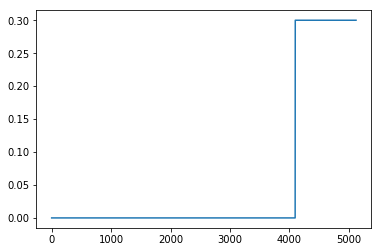

In [14]:
plt.plot(U)

In [15]:
a=np.r_[U, 1*np.ones((XYT_f.shape[0],1)), 2*np.ones((XYT_nearWell.shape[0],1))]

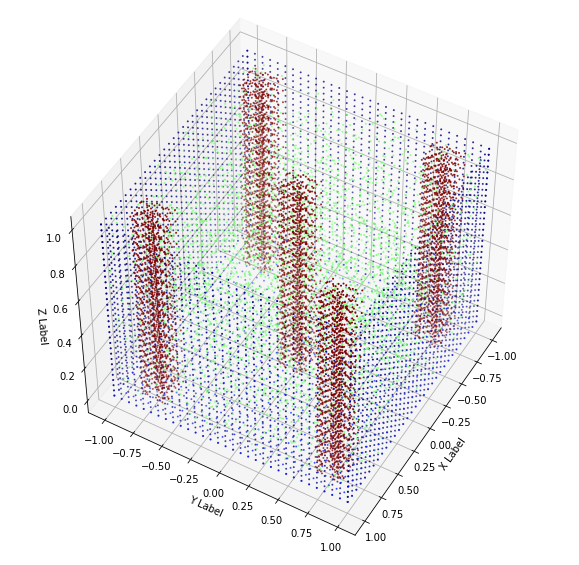

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XYT[:,0],XYT[:,1],XYT[:,2],c = a.flatten(),cmap='jet',s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(50, 30)

In [17]:
Q_inj = np.zeros((XYT.shape[0]))
Q_prd = np.zeros((XYT.shape[0]))

for well in WELLs:

    if well['rate']>0:
        Q_inj = Q_inj + well['rate']*model.Walpha/3.1415927* \
                            np.exp(-model.Walpha*(np.power(XYT[:,0]- well['x'],2)+np.power(XYT[:,1]-well['y'],2)))
    else:
        Q_prd = Q_prd + well['rate']*model.Walpha/3.1415927* \
                            np.exp(-model.Walpha*(np.power(XYT[:,0]- well['x'],2)+np.power(XYT[:,1]-well['y'],2)))


NameError: name 'model' is not defined

In [ ]:
a=np.exp(-model.Walpha*(np.power(XYT[:,0]- well['x'],2)+np.power(XYT[:,1]-well['y'],2)))

In [ ]:
model.Walpha/3.1415927*well['rate']

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.scatter(XYT[:,0],XYT[:,1],c = Q_prd+Q_inj,cmap='jet',s=2)
plt.colorbar()


In [ ]:
print('Initial Condition:      %d points' % n_i)
print('x boundary Condition:   %d points' % n_bx)
print('y boundary Condition:   %d points' % n_by)
print('random collocatiton :   %d points' % XYT_f.shape[0])
print('near well local refine: %d points' % XYT_nearWell.shape[0])
print('i/b conditions        : %d points' % U.shape[0])
print('total points          : %d points' % XYT.shape[0])

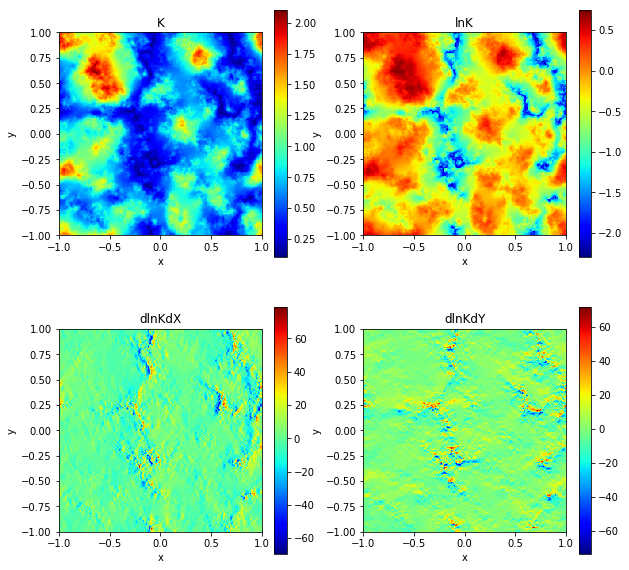

In [18]:
Kmodel = Permeability(np.linspace(-1,1,257),np.linspace(-1,1,257))

In [24]:
model = PhysicsInformedNN(XYT,U,Indices, layers, WELLs, Kmodel, gamma, phi, relpermn)

0 2048 2048 4096 4096 5120
[-1.         -1.          0.         -6.55995459 -6.55995459 -6.55995459
 -6.55995459 -6.55995459]
[1.         1.         1.         0.90618938 0.90618938 0.90618938
 0.90618938 0.34657359]


In [35]:
model.phi

0.2

It: 0, Loss: 3.878e+01, Time: 2.08
It: 50, Loss: 3.668e+01, Time: 1.61
Iter: 00050, Loss: 5.30e+00, sw: 2.64e-02, vx: 4.10e-02, vy: 1.24e-02, fp: 5.17e+00, fs: 3.03e-02, fv: 1.88e-02
Iter: 00100, Loss: 4.94e+00, sw: 5.63e-02, vx: 2.01e-02, vy: 3.14e-02, fp: 4.73e+00, fs: 2.35e-02, fv: 7.52e-02
Iter: 00150, Loss: 1.06e+00, sw: 8.23e-02, vx: 8.77e-03, vy: 5.50e-03, fp: 8.22e-01, fs: 5.10e-02, fv: 8.89e-02
Iter: 00200, Loss: 2.67e-01, sw: 6.65e-02, vx: 3.03e-03, vy: 6.63e-04, fp: 1.83e-01, fs: 4.04e-03, fv: 1.02e-02
Iter: 00250, Loss: 1.03e-01, sw: 6.32e-03, vx: 1.14e-03, vy: 5.40e-04, fp: 8.64e-02, fs: 3.78e-03, fv: 5.14e-03
Iter: 00300, Loss: 3.08e-02, sw: 5.04e-03, vx: 1.09e-03, vy: 6.61e-04, fp: 1.83e-02, fs: 2.09e-03, fv: 3.54e-03
Iter: 00350, Loss: 1.29e-02, sw: 3.95e-03, vx: 2.09e-04, vy: 8.28e-05, fp: 6.81e-03, fs: 8.33e-04, fv: 1.02e-03
Iter: 00400, Loss: 9.75e-03, sw: 3.54e-03, vx: 8.25e-05, vy: 2.74e-05, fp: 4.92e-03, fs: 6.08e-04, fv: 5.74e-04
Iter: 00450, Loss: 7.23e-03, sw: 

/home/qri/miniconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log


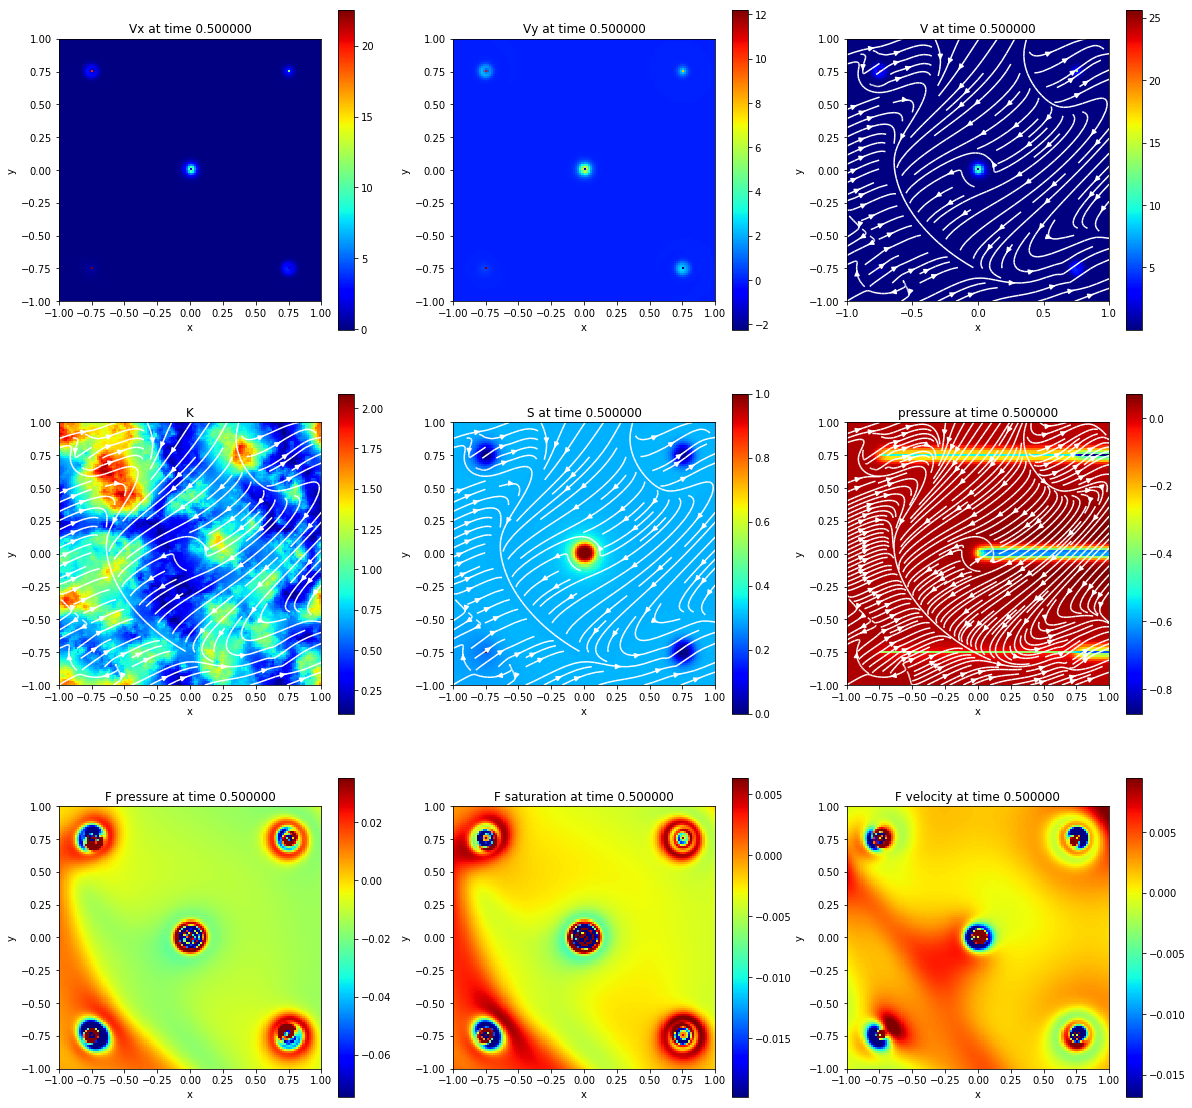

It: 0, Loss: 7.793e-02, Time: 0.03
It: 50, Loss: 6.737e-03, Time: 1.61
Iter: 00050, Loss: 4.59e-03, sw: 2.80e-03, vx: 3.04e-05, vy: 9.16e-06, fp: 1.35e-03, fs: 2.47e-04, fv: 1.51e-04
Iter: 00100, Loss: 4.20e-03, sw: 2.66e-03, vx: 1.93e-05, vy: 7.59e-06, fp: 1.12e-03, fs: 2.54e-04, fv: 1.42e-04
Iter: 00150, Loss: 3.68e-03, sw: 2.35e-03, vx: 1.67e-05, vy: 6.76e-06, fp: 9.80e-04, fs: 1.99e-04, fv: 1.31e-04
Iter: 00200, Loss: 3.25e-03, sw: 2.16e-03, vx: 1.26e-05, vy: 4.32e-06, fp: 7.11e-04, fs: 2.64e-04, fv: 9.98e-05
Iter: 00250, Loss: 3.02e-03, sw: 2.11e-03, vx: 1.07e-05, vy: 3.00e-06, fp: 5.66e-04, fs: 2.41e-04, fv: 9.63e-05
Iter: 00300, Loss: 2.80e-03, sw: 2.07e-03, vx: 2.98e-06, vy: 2.49e-06, fp: 3.96e-04, fs: 2.30e-04, fv: 9.88e-05
Iter: 00350, Loss: 2.66e-03, sw: 2.09e-03, vx: 1.84e-06, vy: 2.82e-06, fp: 2.91e-04, fs: 1.96e-04, fv: 7.20e-05


KeyboardInterrupt: 

In [29]:
for i in range(10):
    start_time = time.time()
    if i<3:
        model.train(100)
    else:
        model.train(0)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    draw_prediction(0.5)

/home/qri/miniconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log


Took 0.019206 second to compute 16641 data points at time 0.000000


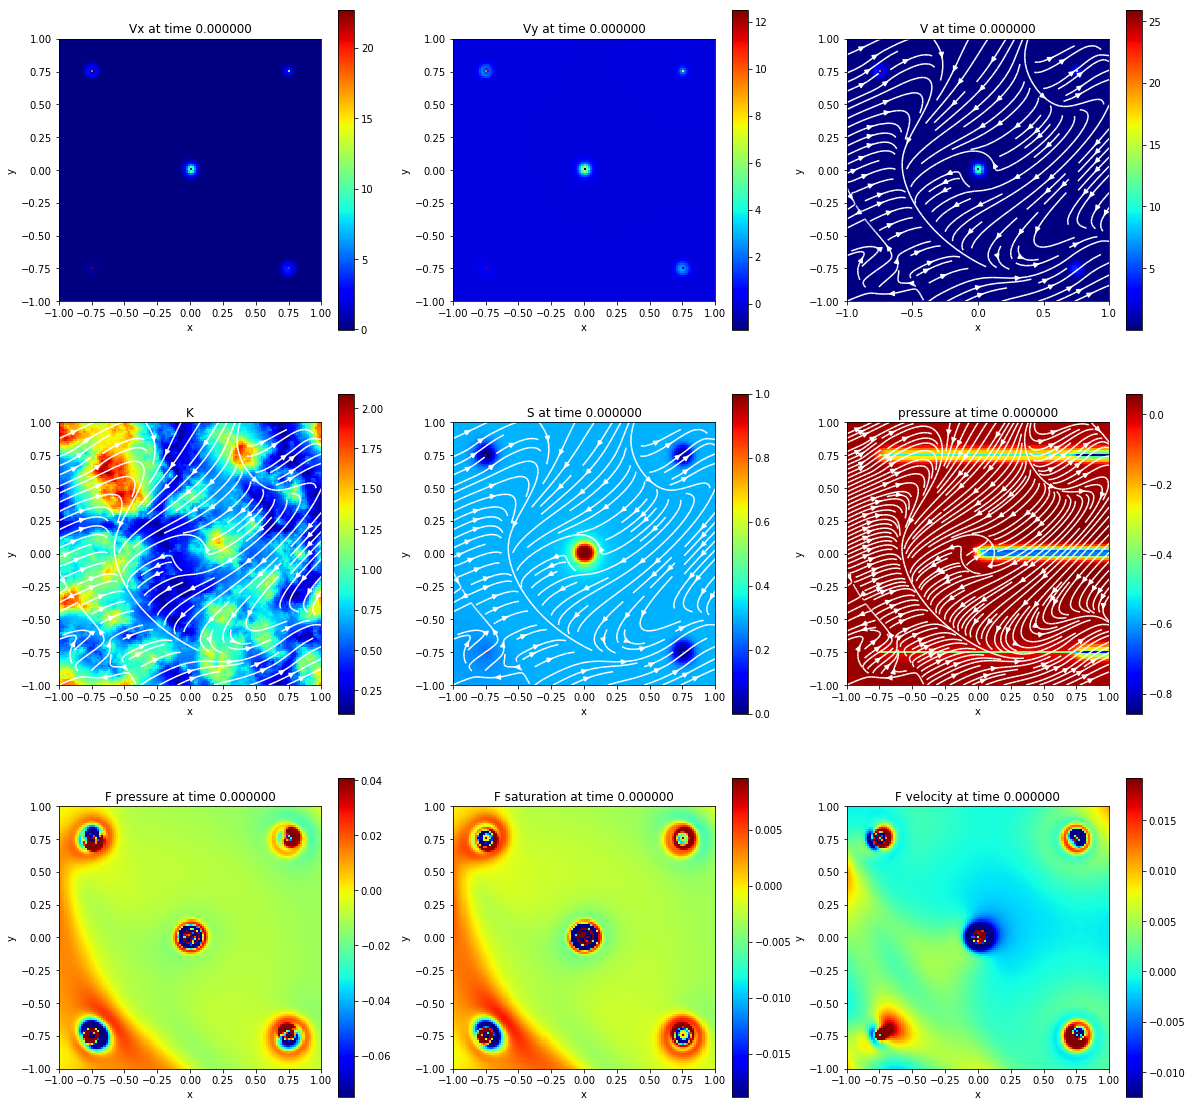

In [33]:
draw_prediction(0)

/home/qri/miniconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log


Took 0.015766 second to compute 16641 data points at time 1.000000


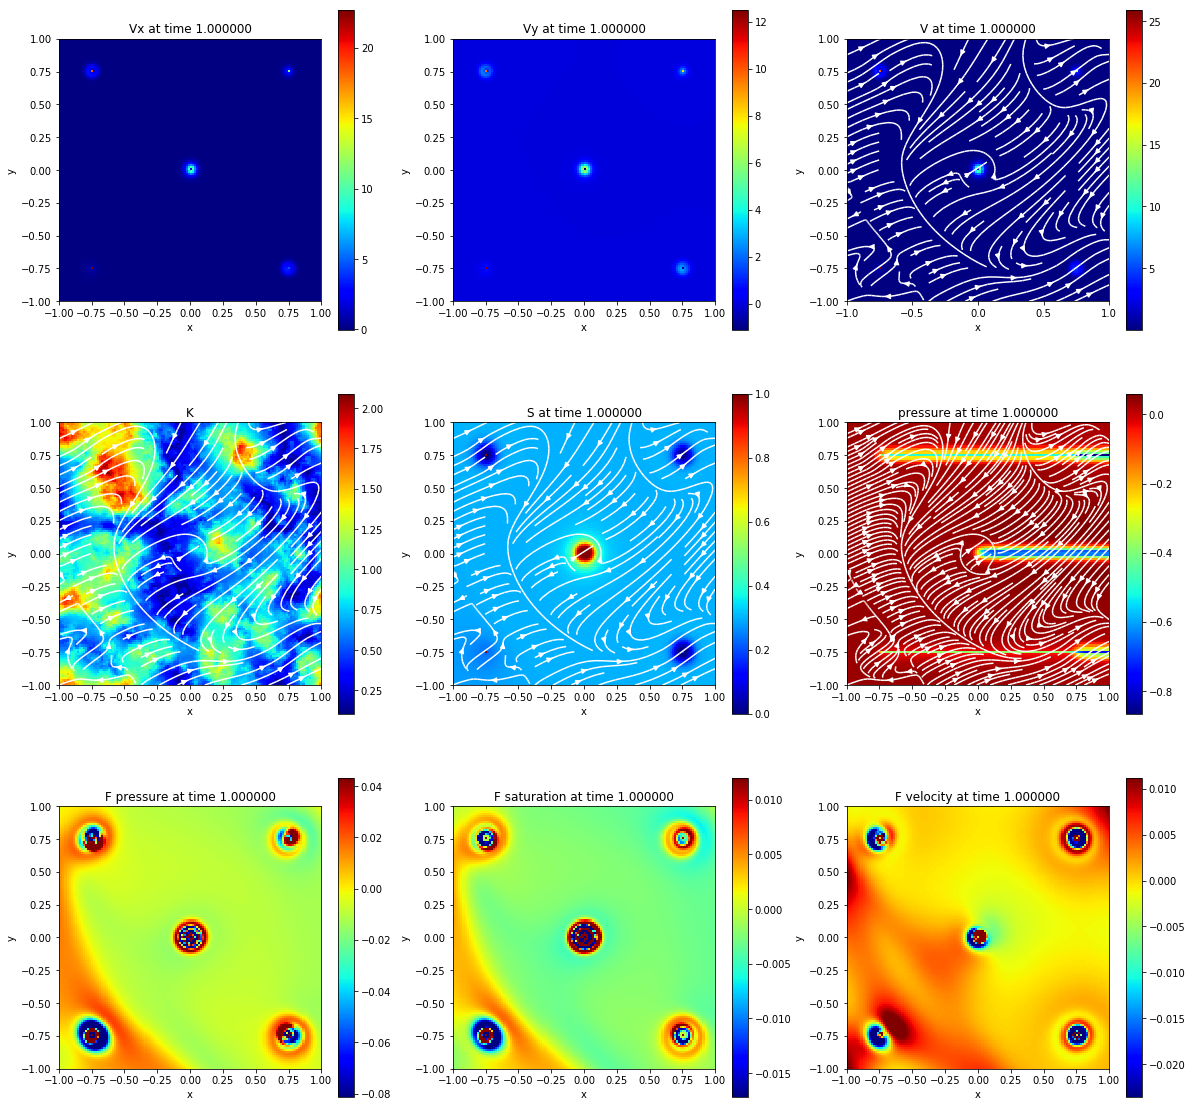

In [34]:
draw_prediction(1)

In [ ]:
saver = tf.train.Saver()
save_path = saver.save(model.sess, "data/dm.ckpt")

In [ ]:
import os
print( os.getcwd() )
print( os.listdir('data') )

In [ ]:
from google.colab import files
files.download( "data/dm.ckpt.meta" ) 
files.download( "data/dm.ckpt.data-00000-of-00001" ) 
files.download( "data/dm.ckpt.index" ) 


In [ ]:
files.download( "data/dm.ckpt.data-00000-of-00001" ) 

In [ ]:
files.download( "data" ) 
